In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
import pickle
import os
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm

In [2]:
# Set larger default figure size for better visibility
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 100

In [3]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
sns.set_style("whitegrid")

In [4]:
df = pd.read_csv('dataset.csv', parse_dates=['Date'], dayfirst=True)

In [5]:
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197161 entries, 0 to 197160
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   SN         197161 non-null  int64         
 1   Commodity  197161 non-null  object        
 2   Date       197161 non-null  datetime64[ns]
 3   Unit       197161 non-null  object        
 4   Minimum    197161 non-null  int64         
 5   Maximum    197161 non-null  int64         
 6   Average    197161 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 10.5+ MB
None


In [6]:
print("\nFirst 5 rows:")
print(df.head())


First 5 rows:
   SN            Commodity       Date Unit  Minimum  Maximum  Average
0   0   Tomato Big(Nepali) 2013-06-16   Kg       35       40     37.5
1   1  Tomato Small(Local) 2013-06-16   Kg       26       32     29.0
2   2           Potato Red 2013-06-16   Kg       20       21     20.5
3   3         Potato White 2013-06-16   Kg       15       16     15.5
4   4   Onion Dry (Indian) 2013-06-16   Kg       28       30     29.0


In [7]:
# Check for null values
print("Null values before handling:")
print(df.isnull().sum())

Null values before handling:
SN           0
Commodity    0
Date         0
Unit         0
Minimum      0
Maximum      0
Average      0
dtype: int64


In [8]:
# Handle null values - fill with forward fill for time series
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)  # in case first values are null

In [9]:
# Check for duplicates
print("\nDuplicate rows before handling:", df.duplicated().sum())
df.drop_duplicates(inplace=True)


Duplicate rows before handling: 0


In [10]:
# Handle categorical values - 'Commodity' and 'Unit' are categorical
print("\nUnique Commodities:", df['Commodity'].unique())
print("Unique Units:", df['Unit'].unique())


Unique Commodities: ['Tomato Big(Nepali)' 'Tomato Small(Local)' 'Potato Red' 'Potato White'
 'Onion Dry (Indian)' 'Carrot(Local)' 'Cabbage(Local)' 'Cauli Local'
 'Raddish Red' 'Raddish White(Local)' 'Brinjal Long' 'Brinjal Round'
 'Cow pea(Long)' 'Green Peas' 'French Bean(Local)' 'Soyabean Green'
 'Bitter Gourd' 'Bottle Gourd' 'Pointed Gourd(Local)' 'Snake Gourd'
 'Smooth Gourd' 'Sponge Gourd' 'Pumpkin' 'Squash(Long)' 'Turnip' 'Okara'
 'Christophine' 'Brd Leaf Mustard' 'Spinach Leaf' 'Cress Leaf'
 'Mustard Leaf' 'Fenugreek Leaf' 'Onion Green' 'Mushroom(Kanya)'
 'Asparagus' 'Neuro' 'Brocauli' 'Sugarbeet' 'Drumstick' 'Red Cabbbage'
 'Lettuce' 'Celery' 'Parseley' 'Fennel Leaf' 'Mint' 'Turnip A' 'Tamarind'
 'Bamboo Shoot' 'Tofu' 'Gundruk' 'Apple(Jholey)' 'Banana' 'Lime'
 'Pomegranate' 'Mango(Maldah)' 'Grapes(Green)' 'Water Melon(Green)'
 'Sweet Orange' 'Pineapple' 'Cucumber(Local)' 'Jack Fruit'
 'Papaya(Nepali)' 'Sugarcane' 'Ginger' 'Chilli Dry' 'Chilli Green'
 'Capsicum' 'Garlic Green' '

In [11]:
# Since we'll filter by commodity, we don't need to encode it now
# Unit is consistent (all 'Kg'), so we can drop it
if df['Unit'].nunique() == 1:
    df.drop('Unit', axis=1, inplace=True)

In [12]:
# Convert date to datetime and set as index for time series analysis
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.sort_values('Date', inplace=True)

In [13]:
# Add time-based features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['DayOfYear'] = df['Date'].dt.dayofyear

In [14]:
print("\nAfter preprocessing:")
print(df.head())


After preprocessing:
    SN           Commodity       Date Unit  Minimum  Maximum  Average  Year  \
0    0  Tomato Big(Nepali) 2013-06-16   Kg       35       40     37.5  2013   
53  53         Pomegranate 2013-06-16   Kg      200      220    210.0  2013   
52  52                Lime 2013-06-16   Kg      200      400    300.0  2013   
51  51              Banana 2013-06-16  Doz       70       80     75.0  2013   
50  50       Apple(Jholey) 2013-06-16   Kg      100      120    110.0  2013   

    Month  Day  DayOfWeek  DayOfYear  
0       6   16          6        167  
53      6   16          6        167  
52      6   16          6        167  
51      6   16          6        167  
50      6   16          6        167  


In [15]:
def process_commodity_data(commodity_df):
    """Process data for a specific commodity"""
    # Outlier detection using IQR
    for col in ['Minimum', 'Maximum', 'Average']:
        Q1 = commodity_df[col].quantile(0.25)
        Q3 = commodity_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Cap outliers
        commodity_df[col] = np.where(commodity_df[col] < lower_bound, lower_bound, 
                                    np.where(commodity_df[col] > upper_bound, upper_bound, 
                                            commodity_df[col]))
    
    # Feature selection - we'll focus on 'Average' price for forecasting
    ts_data = commodity_df.set_index('Date')['Average']
    
    return ts_data

In [16]:
def visualize_commodity_data(ts_data, commodity_name):
    """Generate and display individual visualization plots for a commodity"""
    # Create directory for saving plots
    os.makedirs('visualizations', exist_ok=True)
    
    # 1. Time series plot
    plt.figure(figsize=(15, 6))
    ts_data.plot(title=f'{commodity_name} Price Over Time')
    plt.tight_layout()
    plt.savefig(f'visualizations/{commodity_name}_time_series.png', dpi=100)
    plt.show()
    
    # 2. Seasonal decomposition plot
    plt.figure(figsize=(15, 8))
    result = seasonal_decompose(ts_data, model='additive', period=30)
    result.plot()
    plt.suptitle(f'{commodity_name} Seasonal Decomposition', y=1.02)
    plt.tight_layout()
    plt.savefig(f'visualizations/{commodity_name}_seasonal_decompose.png', dpi=100)
    plt.show()
    
    # 3. ACF plot
    plt.figure(figsize=(15, 5))
    plot_acf(ts_data, lags=50)
    plt.title(f'{commodity_name} Autocorrelation')
    plt.tight_layout()
    plt.savefig(f'visualizations/{commodity_name}_acf.png', dpi=100)
    plt.show()
    
    # 4. PACF plot
    plt.figure(figsize=(15, 5))
    plot_pacf(ts_data, lags=50)
    plt.title(f'{commodity_name} Partial Autocorrelation')
    plt.tight_layout()
    plt.savefig(f'visualizations/{commodity_name}_pacf.png', dpi=100)
    plt.show()
    
    # 5. Distribution plot
    plt.figure(figsize=(15, 6))
    sns.histplot(ts_data, kde=True)
    plt.title(f'{commodity_name} Price Distribution')
    plt.tight_layout()
    plt.savefig(f'visualizations/{commodity_name}_distribution.png', dpi=100)
    plt.show()
    
    # 6. Monthly boxplot
    plt.figure(figsize=(15, 6))
    sns.boxplot(x=ts_data.index.month, y=ts_data.values)
    plt.title(f'{commodity_name} Monthly Price Distribution')
    plt.xlabel('Month')
    plt.ylabel('Price')
    plt.tight_layout()
    plt.savefig(f'visualizations/{commodity_name}_monthly_boxplot.png', dpi=100)
    plt.show()

In [17]:
def train_test_split(ts_data, test_size=0.2):
    """Split time series data into train and test sets"""
    split_idx = int(len(ts_data) * (1 - test_size))
    train = ts_data[:split_idx]
    test = ts_data[split_idx:]
    return train, test

In [18]:
def build_arima_model(train_data):
    """Build and train ARIMA model with auto parameter selection"""
    # Auto ARIMA to find best parameters
    model = pm.auto_arima(train_data, 
                          seasonal=True, 
                          m=12, 
                          stepwise=True,
                          suppress_warnings=True, 
                          trace=True)
    
    print(f"Best ARIMA parameters: {model.order}")
    return model

In [19]:
def evaluate_arima_model(model, train_data, test_data):
    """Evaluate ARIMA model performance"""
    # ARIMA evaluation - skip first 'd' points where d is the differencing order
    d = model.order[1]
    train_pred = model.predict_in_sample(start=d, end=len(train_data)-1)
    
    # Align predictions with original data
    full_train_pred = np.empty(len(train_data))
    full_train_pred[:] = np.nan
    full_train_pred[d:] = train_pred
    
    test_pred, conf_int = model.predict(n_periods=len(test_data), return_conf_int=True)
    
    # Calculate metrics (only on non-nan values)
    train_mae = mean_absolute_error(train_data[d:], train_pred)
    train_rmse = np.sqrt(mean_squared_error(train_data[d:], train_pred))
    test_mae = mean_absolute_error(test_data, test_pred)
    test_rmse = np.sqrt(mean_squared_error(test_data, test_pred))
    
    return {
        'train_pred': pd.Series(full_train_pred, index=train_data.index),
        'test_pred': pd.Series(test_pred, index=test_data.index),
        'conf_int': conf_int,
        'metrics': {
            'Train MAE': train_mae,
            'Train RMSE': train_rmse,
            'Test MAE': test_mae,
            'Test RMSE': test_rmse
        }
    }

In [20]:
def save_model(model, commodity_name):
    """Save trained ARIMA model to file"""
    os.makedirs('saved_models', exist_ok=True)
    filename = f"saved_models/{commodity_name.replace(' ', '_')}_ARIMA.pkl"
    
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
    
    print(f"Saved ARIMA model to {filename}")

In [21]:
def load_model(commodity_name):
    """Load trained ARIMA model from file"""
    filename = f"saved_models/{commodity_name.replace(' ', '_')}_ARIMA.pkl"
    
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [22]:
def forecast_future(model, history, steps):
    """Forecast future values using the trained ARIMA model"""
    forecast, conf_int = model.predict(n_periods=steps, return_conf_int=True)
    return forecast, conf_int

In [23]:
def commodity_price_pipeline(commodity_name, steps_to_forecast=30):
    """Complete pipeline for commodity price forecasting using ARIMA with individual plots"""
    print(f"\n{'='*50}")
    print(f"Processing commodity: {commodity_name}")
    print(f"{'='*50}")
    
    # Filter data for the selected commodity
    commodity_df = df[df['Commodity'] == commodity_name].copy()
    
    if len(commodity_df) < 100:
        print(f"Warning: Insufficient data ({len(commodity_df)} records) for {commodity_name}")
        return None
    
    # Process data
    ts_data = process_commodity_data(commodity_df)
    
    # Visualize data (already handles individual plots)
    visualize_commodity_data(ts_data, commodity_name)
    
    # Train-test split
    train_data, test_data = train_test_split(ts_data)
    
    # Plot train-test split
    plt.figure(figsize=(15, 6))
    plt.plot(train_data.index, train_data, label='Training Data', color='blue')
    plt.plot(test_data.index, test_data, label='Test Data', color='orange')
    plt.title(f'{commodity_name} Train-Test Split')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'visualizations/{commodity_name}_train_test_split.png', dpi=100)
    plt.show()
    
    # Model training
    print("\nTraining ARIMA model...")
    arima_model = build_arima_model(train_data)
    
    # Model evaluation
    print("\nEvaluating ARIMA model...")
    arima_results = evaluate_arima_model(arima_model, train_data, test_data)
    
    # Plot 1: Training predictions
    plt.figure(figsize=(15, 6))
    plt.plot(train_data.index, train_data, label='Actual Prices', color='blue')
    plt.plot(arima_results['train_pred'].index, 
             arima_results['train_pred'], 
             label='ARIMA Predictions', 
             color='red', 
             alpha=0.7)
    plt.title(f'{commodity_name} ARIMA Training Performance')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'visualizations/{commodity_name}_arima_training.png', dpi=100)
    plt.show()
    
    # Plot 2: Test predictions
    plt.figure(figsize=(15, 6))
    plt.plot(test_data.index, test_data, label='Actual Prices', color='blue')
    plt.plot(arima_results['test_pred'].index, 
             arima_results['test_pred'], 
             label='ARIMA Predictions', 
             color='green', 
             linestyle='--')
    
    if 'conf_int' in arima_results:
        plt.fill_between(arima_results['test_pred'].index,
                        arima_results['conf_int'][:, 0],
                        arima_results['conf_int'][:, 1],
                        color='gray', alpha=0.2, label='Confidence Interval')
    
    plt.title(f'{commodity_name} ARIMA Test Performance')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'visualizations/{commodity_name}_arima_test_predictions.png', dpi=100)
    plt.show()
    
    # Save model
    save_model(arima_model, commodity_name)
    
    # Forecast future values
    print(f"\nForecasting next {steps_to_forecast} days...")
    forecast, conf_int = forecast_future(arima_model, ts_data, steps_to_forecast)
    
    # Create future dates
    last_date = ts_data.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), 
                                periods=steps_to_forecast)
    
    # Plot 3: Full history with forecast
    plt.figure(figsize=(15, 6))
    plt.plot(ts_data.index, ts_data.values, label='Historical Prices', color='blue')
    plt.plot(future_dates, forecast, label='Forecasted Prices', color='red', linestyle='--')
    
    if conf_int is not None:
        plt.fill_between(future_dates,
                        conf_int[:, 0],
                        conf_int[:, 1],
                        color='orange', alpha=0.2, label='Confidence Interval')
    
    plt.title(f'{commodity_name} Price Forecast (ARIMA)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'visualizations/{commodity_name}_forecast.png', dpi=100)
    plt.show()
    
    # Plot 4: Zoomed-in forecast view
    plt.figure(figsize=(15, 6))
    if len(ts_data) > 180:  # Show last 6 months if we have enough data
        last_six_months = ts_data.index[-180]
        plt.plot(ts_data[last_six_months:].index, 
                 ts_data[last_six_months:].values, 
                 label='Recent Prices', 
                 color='blue')
    else:
        plt.plot(ts_data.index, ts_data.values, label='Historical Prices', color='blue')
    
    plt.plot(future_dates, forecast, label='Forecasted Prices', color='red', linestyle='--')
    
    if conf_int is not None:
        plt.fill_between(future_dates,
                        conf_int[:, 0],
                        conf_int[:, 1],
                        color='orange', alpha=0.2, label='Confidence Interval')
    
    plt.title(f'{commodity_name} Recent Trend & Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'visualizations/{commodity_name}_forecast_zoom.png', dpi=100)
    plt.show()
    
    # Create forecast dataframe
    forecast_df = pd.DataFrame({
        'Date': future_dates,
        'Forecasted_Price': forecast
    })
    
    if conf_int is not None:
        forecast_df['Lower_Bound'] = conf_int[:, 0]
        forecast_df['Upper_Bound'] = conf_int[:, 1]
    
    print("\nForecasted Prices:")
    print(forecast_df.head())
    
    return {
        'commodity': commodity_name,
        'metrics': arima_results['metrics'],
        'forecast': forecast_df
    }

In [24]:
# Get list of available commodities
available_commodities = df['Commodity'].unique()
print("Available Commodities:")
for i, comm in enumerate(available_commodities):
    print(f"{i+1}. {comm}")

Available Commodities:
1. Tomato Big(Nepali)
2. Pomegranate
3. Lime
4. Banana
5. Apple(Jholey)
6. Gundruk
7. Tofu
8. Bamboo Shoot
9. Tamarind
10. Turnip A
11. Mint
12. Fennel Leaf
13. Parseley
14. Celery
15. Lettuce
16. Red Cabbbage
17. Grapes(Green)
18. Drumstick
19. Water Melon(Green)
20. Pineapple
21. Fish Fresh
22. Clive Green
23. Clive Dry
24. Garlic Dry Nepali
25. Garlic Dry Chinese
26. Coriander Green
27. Garlic Green
28. Capsicum
29. Chilli Green
30. Chilli Dry
31. Ginger
32. Sugarcane
33. Papaya(Nepali)
34. Jack Fruit
35. Cucumber(Local)
36. Sweet Orange
37. Sugarbeet
38. Mango(Maldah)
39. Neuro
40. Soyabean Green
41. French Bean(Local)
42. Green Peas
43. Cow pea(Long)
44. Brinjal Round
45. Brinjal Long
46. Raddish White(Local)
47. Raddish Red
48. Cauli Local
49. Cabbage(Local)
50. Carrot(Local)
51. Onion Dry (Indian)
52. Potato White
53. Potato Red
54. Brocauli
55. Bitter Gourd
56. Bottle Gourd
57. Tomato Small(Local)
58. Snake Gourd
59. Pointed Gourd(Local)
60. Mushroom(Kany

In [25]:
# Select commodity (change this to the desired commodity)
selected_commodity = available_commodities[0]  # Default to first commodity
print(f"\nSelected Commodity: {selected_commodity}")


Selected Commodity: Tomato Big(Nepali)



Processing commodity: Tomato Big(Nepali)


<Figure size 1500x800 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

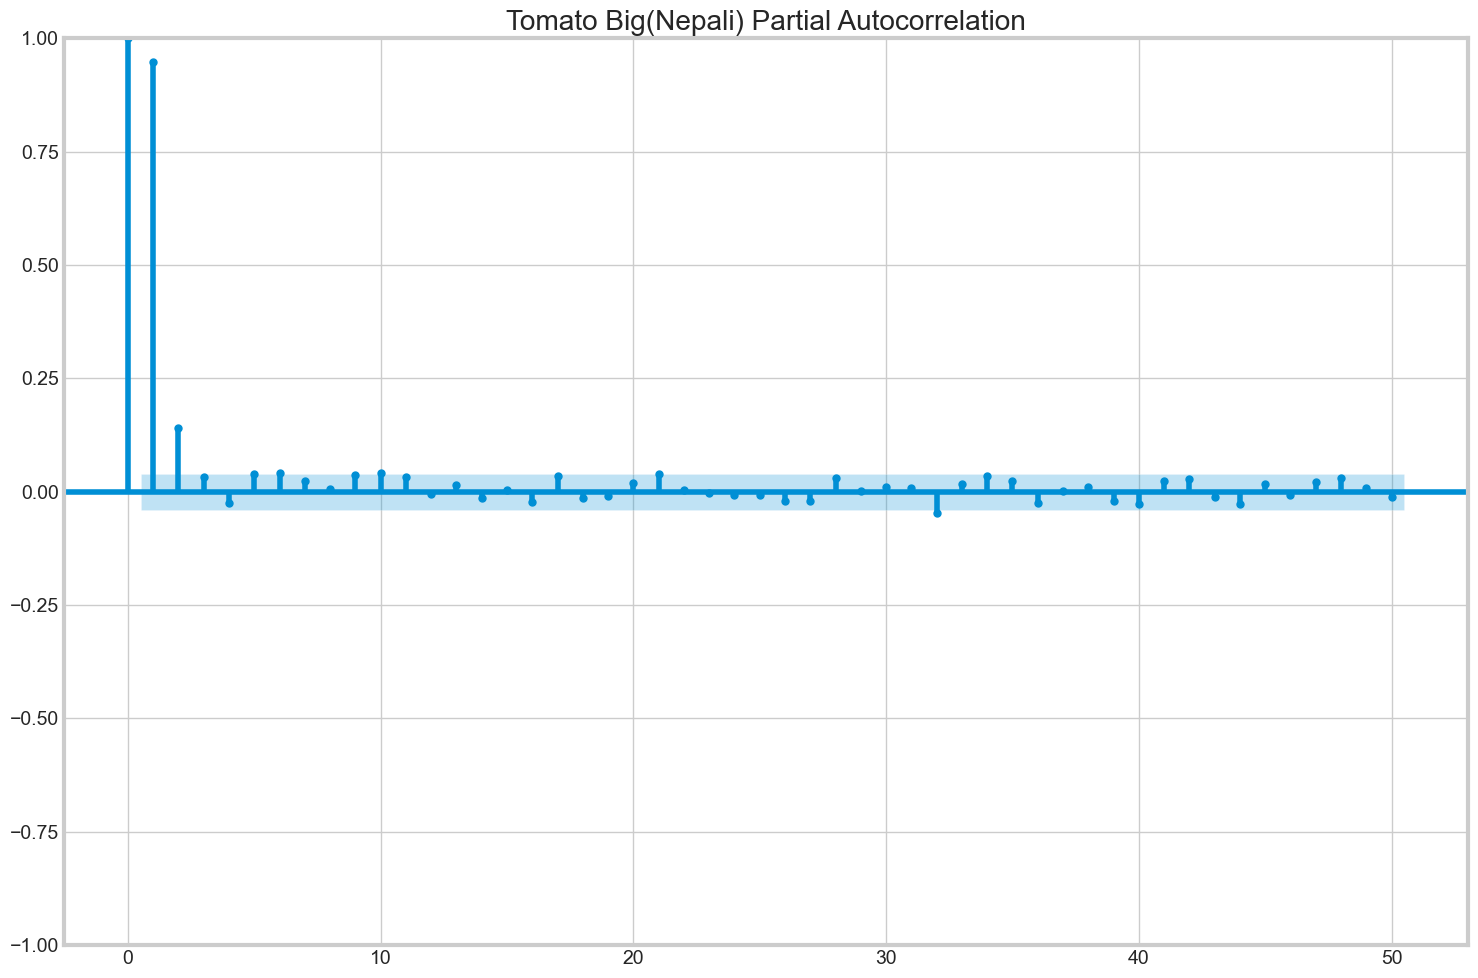

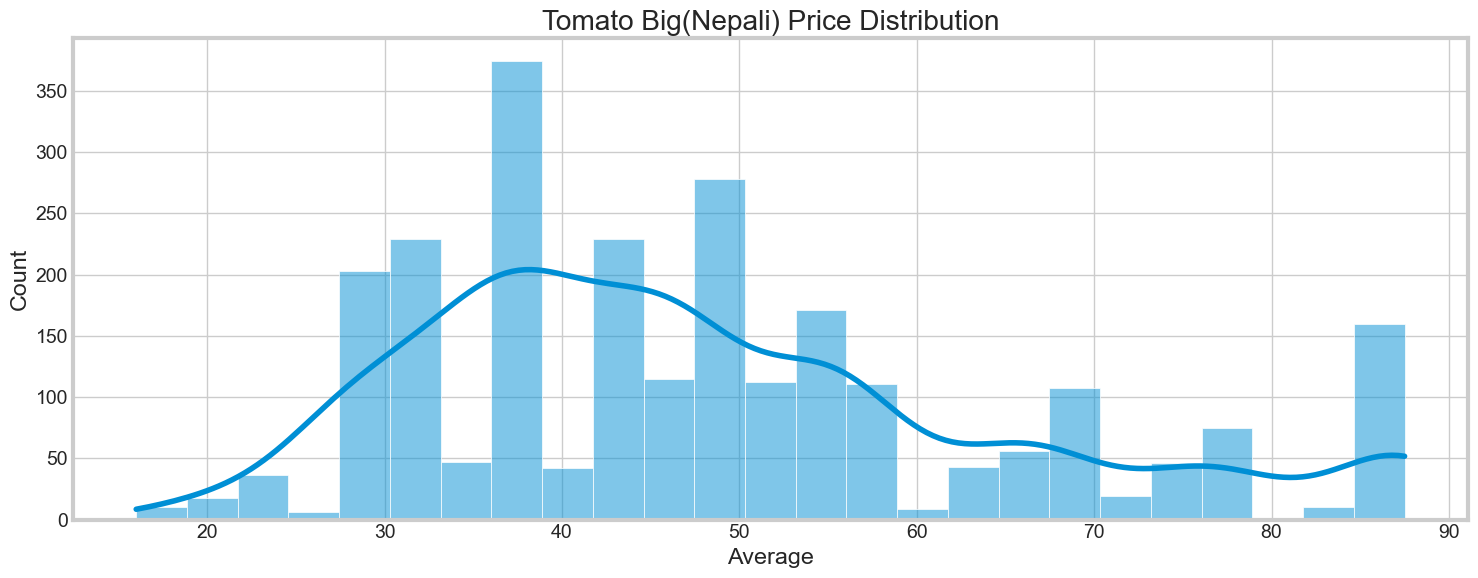

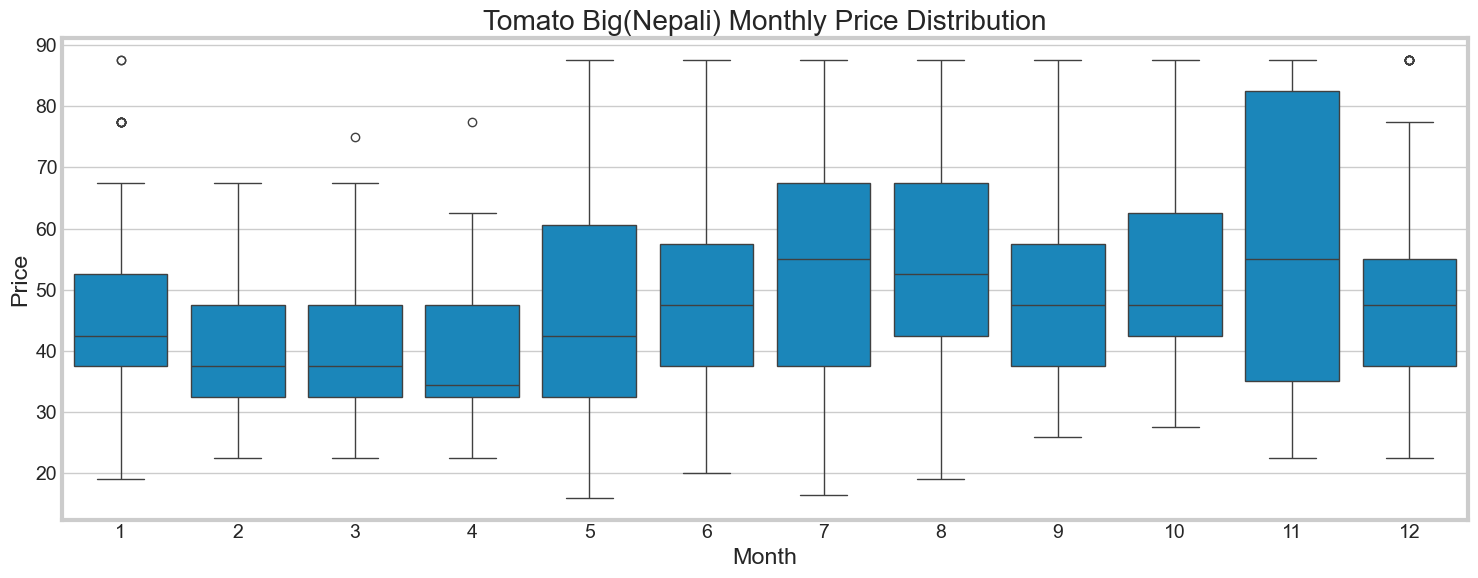

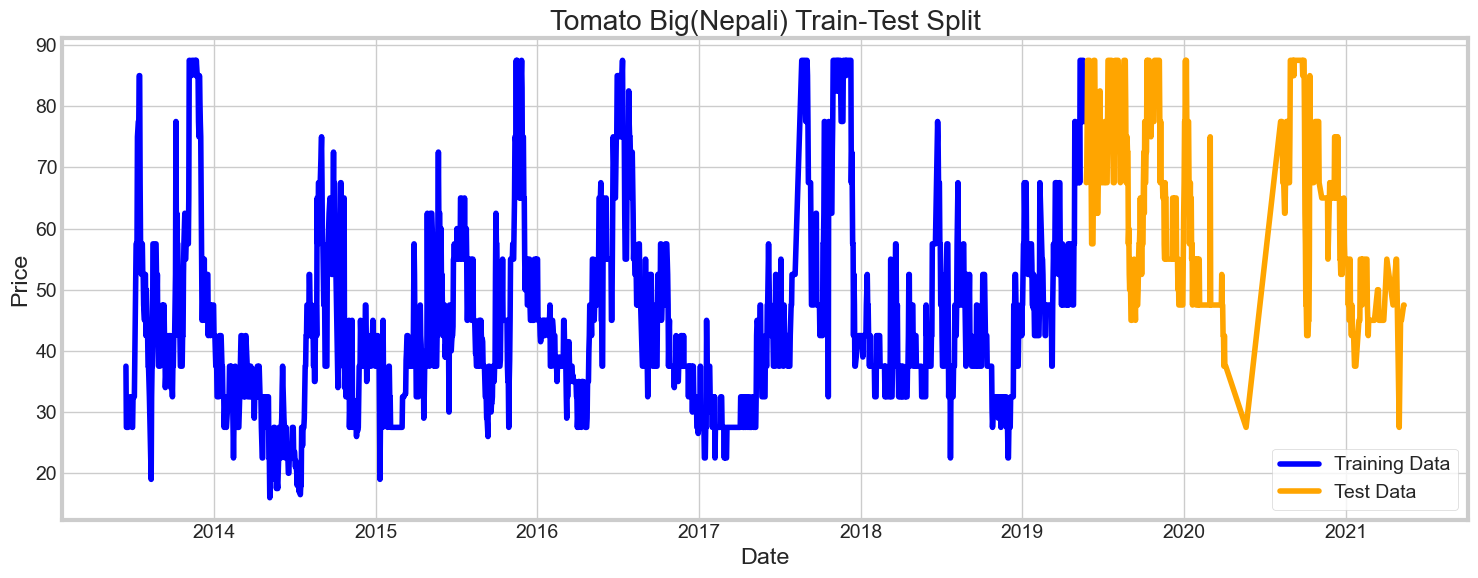


Training ARIMA model...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=3.50 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=12346.711, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=12299.006, Time=0.38 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=12293.514, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=12344.740, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=12291.564, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=12293.513, Time=0.31 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=12295.508, Time=0.55 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=12281.791, Time=0.40 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=12283.541, Time=0.91 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=12283.540, Time=1.18 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=12285.544, Time=1.33 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=12297.051, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=12293.489, 

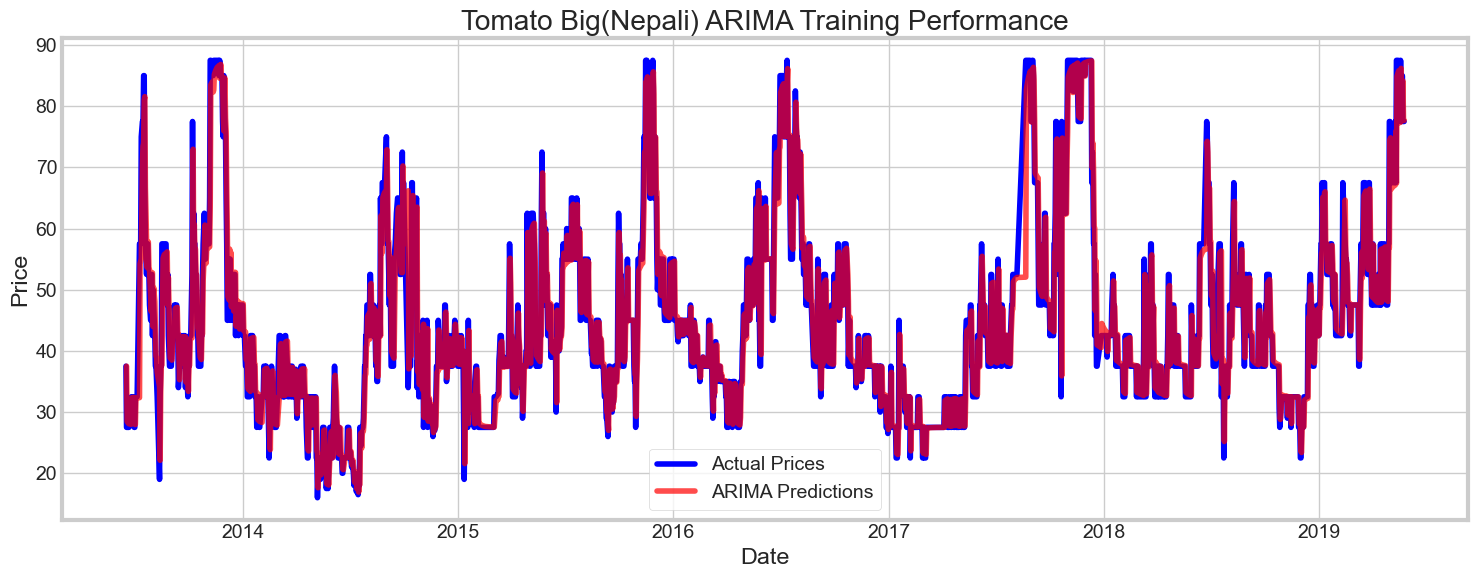

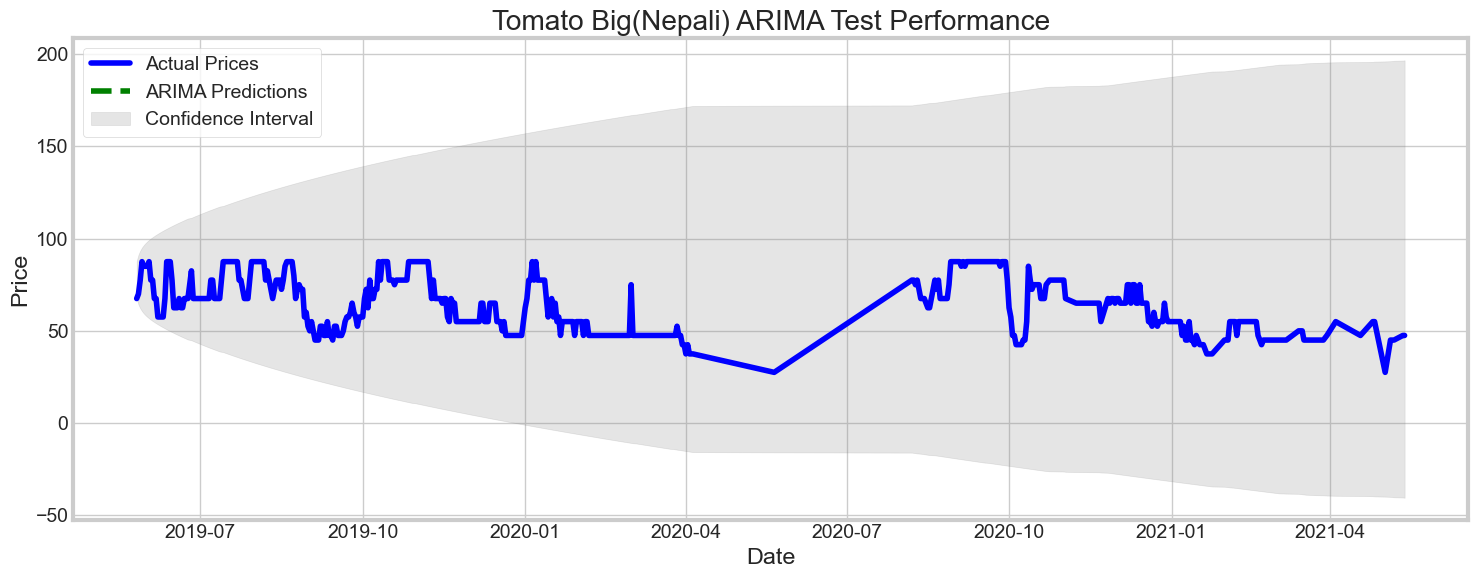

Saved ARIMA model to saved_models/Tomato_Big(Nepali)_ARIMA.pkl

Forecasting next 200 days...


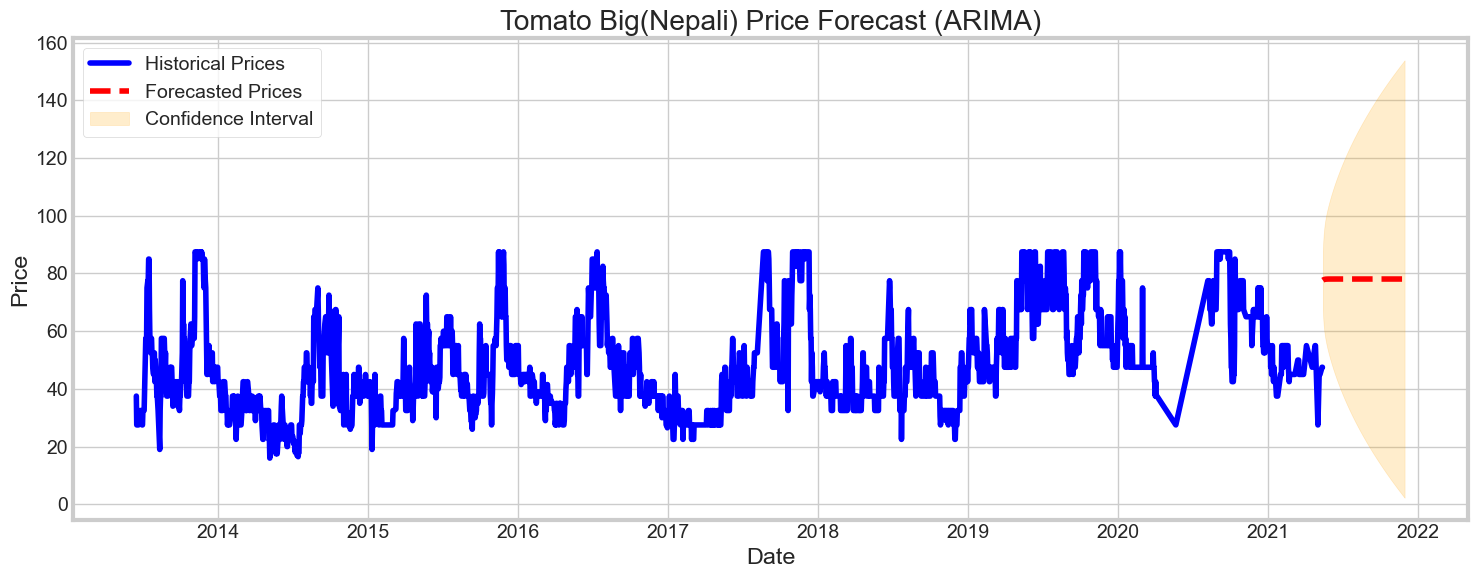

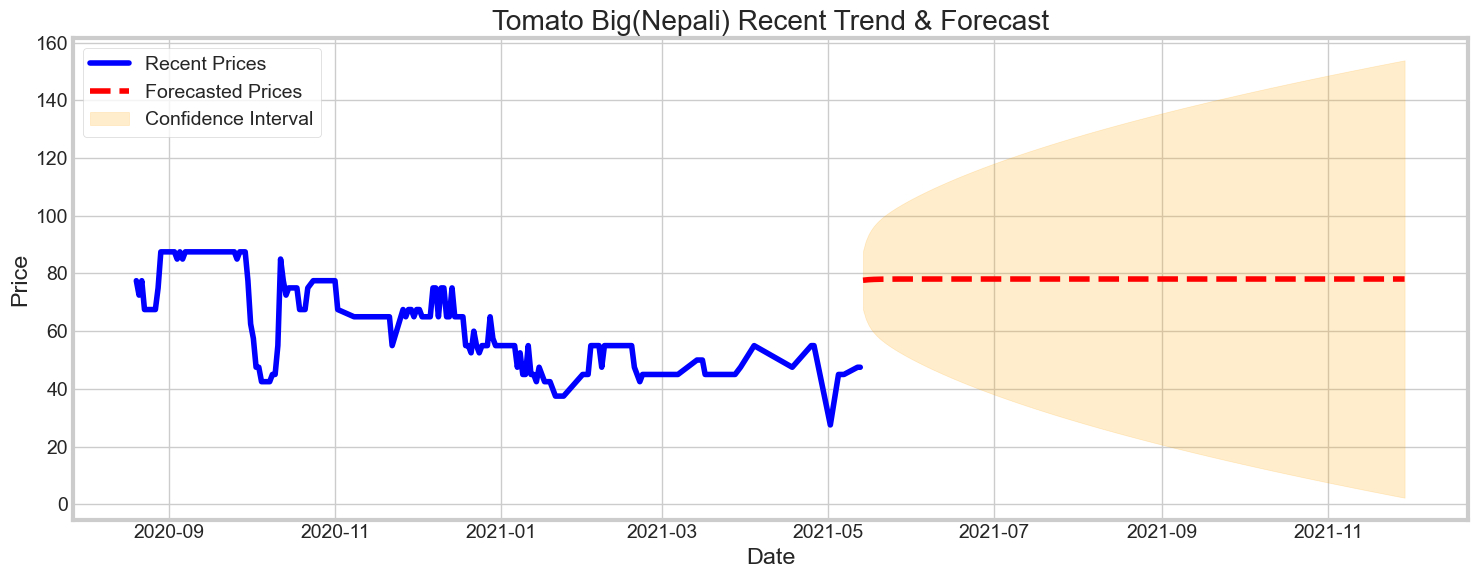


Forecasted Prices:
           Date  Forecasted_Price  Lower_Bound  Upper_Bound
2005 2021-05-14         77.651539    67.513389    87.789688
2006 2021-05-15         77.763591    64.297902    91.229280
2007 2021-05-16         77.846445    62.224749    93.468141
2008 2021-05-17         77.907710    60.697561    95.117859
2009 2021-05-18         77.953011    59.482552    96.423471


In [26]:
# Run pipeline
results = commodity_price_pipeline(selected_commodity, steps_to_forecast=200)

In [27]:
# Display final results
if results:
    print("\nFinal Results:")
    print("\nPerformance Metrics:")
    print(pd.DataFrame(results['metrics'], index=['ARIMA']))
    print("\nForecast Summary:")
    print(results['forecast'].describe())


Final Results:

Performance Metrics:
       Train MAE  Train RMSE   Test MAE  Test RMSE
ARIMA   3.125328    5.172838  18.042442  21.282708

Forecast Summary:
                      Date  Forecasted_Price  Lower_Bound  Upper_Bound
count                  200        200.000000   200.000000   200.000000
mean   2021-08-21 12:00:00         78.073312    25.664406   130.482217
min    2021-05-14 00:00:00         77.651539     2.277813    87.789688
25%    2021-07-02 18:00:00         78.081563    11.907638   118.634621
50%    2021-08-21 12:00:00         78.081563    23.201980   132.961146
75%    2021-10-10 06:00:00         78.081563    37.528505   144.255489
max    2021-11-29 00:00:00         78.081563    67.513389   153.885314
std                    NaN          0.044517    16.207504    16.245231
